In [1]:
!pip install pymorphy2

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 40.1 MB/s eta 0:00:0000:0100:01


In [2]:
import torch
import pandas as pd
import numpy as np


from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from sklearn.model_selection import train_test_split

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist



In [3]:
max_words = 2000
max_len = 20
num_classes = 1

# Training
epochs = 10
batch_size = 512
print_batch_n = 100

In [4]:
DIR_PATH = '/kaggle/input/twitter-sentiment-analysis-hatred-speech/'

In [5]:
df_train = pd.read_csv(DIR_PATH + "train.csv")
df_test = pd.read_csv(DIR_PATH + "test.csv")

In [6]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
df_train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [8]:
df_test.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid ð #hairflip #neverre...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [9]:
df_train, df_val = train_test_split(df_train, test_size=0.25, random_state=42)

In [10]:
df_train.shape, df_val.shape

((23971, 3), (7991, 3))

In [11]:
sw = set(get_stop_words("en"))
#sw

In [12]:
puncts = set(punctuation)
#puncts

In [13]:
morpher = MorphAnalyzer()

In [14]:
def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
#     txt = re.sub(r".?\\[\w|\d]*", "", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [15]:
df_train['tweet'].iloc[:5].values

array(['have a   weekend ',
       "the world really is going bonkers and it's  really bad atm. #shootings #deathstroke #violence #hooligans at the euro. so   :*(",
       'made my night hahahha ',
       "she's looking like a really good person, stupid &amp; insane killer,  my condolences to his family!   @user #uk",
       'must be the first year ever where xbox and playstation killed their #e32016 conferences!  '],
      dtype=object)

In [16]:
df_train['tweet'].iloc[:5].apply(preprocess_text).values

array(['weekend',
       'world really going bonkers really bad atm shootings deathstroke violence hooligans euro',
       'made night hahahha',
       'shes looking like really good person stupid amp insane killer condolences family user uk',
       'must first year ever xbox playstation killed e32016 conferences'],
      dtype=object)

In [17]:
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 17197/17197 [00:05<00:00, 3323.60it/s]


In [18]:
train_corpus = " ".join(df_train['tweet'])
train_corpus = train_corpus.lower()

In [19]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['weekend', 'world', 'really', 'going', 'bonkers']

In [20]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [21]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [22]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'u', 'im', 'life']

In [23]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
# vocabulary

In [24]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [25]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])


CPU times: user 8.6 s, sys: 19.2 ms, total: 8.62 s
Wall time: 8.66 s


In [26]:
df_train['tweet'].iloc[0]

'weekend'

In [27]:
x_train[0]

array([34,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)
    
    
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [29]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [30]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [31]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 20])
torch.Size([512])
tensor(0)


### LSTM

In [32]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [33]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 271381


In [34]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zeroing the gradient
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # calculating errors in training
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # we output statistics about the learning process
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # we output statistics on test data
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # counting errors on the test
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # calculating metrics on a test
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/10]. Step [47/47]. Loss: 0.305. Acc: 0.930. Test loss: 0.416. Test acc: 0.930
Epoch [2/10]. Step [47/47]. Loss: 0.246. Acc: 0.930. Test loss: 0.451. Test acc: 0.930
Epoch [3/10]. Step [47/47]. Loss: 0.245. Acc: 0.930. Test loss: 0.327. Test acc: 0.930
Epoch [4/10]. Step [47/47]. Loss: 0.193. Acc: 0.930. Test loss: 0.210. Test acc: 0.934
Epoch [5/10]. Step [47/47]. Loss: 0.163. Acc: 0.940. Test loss: 0.029. Test acc: 0.945
Epoch [6/10]. Step [47/47]. Loss: 0.199. Acc: 0.947. Test loss: 0.534. Test acc: 0.949
Epoch [7/10]. Step [47/47]. Loss: 0.122. Acc: 0.951. Test loss: 0.033. Test acc: 0.949
Epoch [8/10]. Step [47/47]. Loss: 0.183. Acc: 0.954. Test loss: 0.137. Test acc: 0.946
Epoch [9/10]. Step [47/47]. Loss: 0.141. Acc: 0.955. Test loss: 0.708. Test acc: 0.948
Epoch [10/10]. Step [47/47]. Loss: 0.130. Acc: 0.957. Test loss: 1.219. Test acc: 0.945
Training is finished!


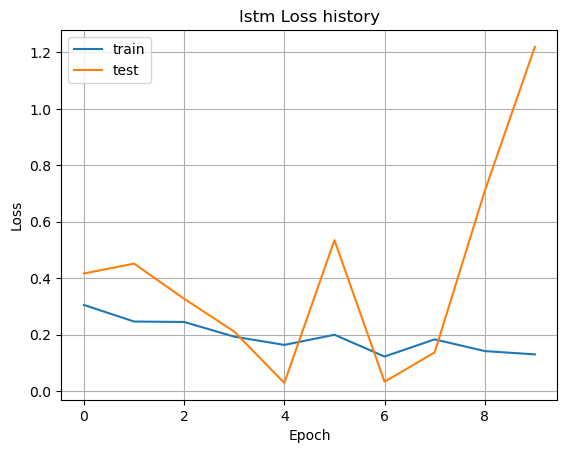

In [35]:
import matplotlib.pyplot as plt

plt.title('lstm Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

### GRU

In [36]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [37]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 267541


In [38]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # zeroing the gradient
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # calculating errors in training
        loss = loss.item()
        running_items += len(labels)
        # calculating metrics for training
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # we output statistics about the learning process
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # we output statistics on test data
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # counting errors on the test
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # calculating metrics on a test
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/10]. Step [47/47]. Loss: 0.293. Acc: 0.797. Test loss: 0.214. Test acc: 0.930
Epoch [2/10]. Step [47/47]. Loss: 0.223. Acc: 0.930. Test loss: 0.403. Test acc: 0.930
Epoch [3/10]. Step [47/47]. Loss: 0.247. Acc: 0.931. Test loss: 0.459. Test acc: 0.936
Epoch [4/10]. Step [47/47]. Loss: 0.189. Acc: 0.940. Test loss: 0.042. Test acc: 0.946
Epoch [5/10]. Step [47/47]. Loss: 0.121. Acc: 0.949. Test loss: 0.893. Test acc: 0.949
Epoch [6/10]. Step [47/47]. Loss: 0.150. Acc: 0.953. Test loss: 0.453. Test acc: 0.949
Epoch [7/10]. Step [47/47]. Loss: 0.149. Acc: 0.954. Test loss: 0.026. Test acc: 0.950
Epoch [8/10]. Step [47/47]. Loss: 0.135. Acc: 0.957. Test loss: 0.023. Test acc: 0.950
Epoch [9/10]. Step [47/47]. Loss: 0.096. Acc: 0.958. Test loss: 0.364. Test acc: 0.951
Epoch [10/10]. Step [47/47]. Loss: 0.107. Acc: 0.961. Test loss: 0.169. Test acc: 0.952
Training is finished!


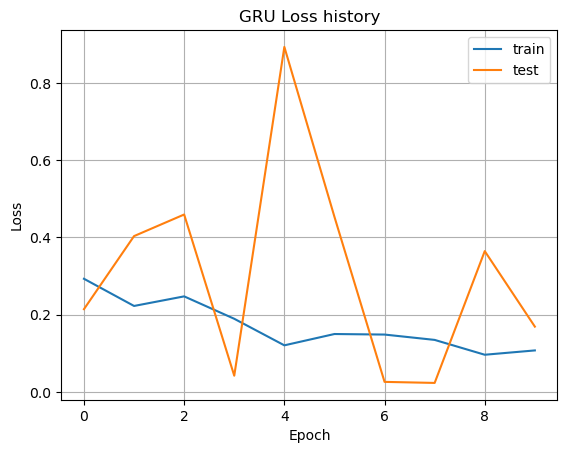

In [39]:
import matplotlib.pyplot as plt

plt.title('GRU Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()